In [83]:
import os
import sys
import time
from enum import Enum

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from functional import seq
from math import sqrt
from multiprocessing import Pool

# Load the "autoreload" extension
% reload_ext autoreload

# always reload modules marked with "%aimport"
% autoreload 1

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, os.pardir, 'src')
sys.path.append(src_dir)

In [112]:
class PeriodColumns(Enum):
    ID = 'id'
    OPEN = 'open'
    CLOSE = 'close'
    HIGH = 'high'
    LOW = 'low'
    VOLUME = 'volume'
    WEIGHTED_AVERAGE = 'weightedAverage'
    BASE_PRICE = 'basePrice'
    BASE_PRICE_BIN = 'basePriceBin'

    def __init__(self, column_name):
        self.column_name = column_name


class BinColumns(Enum):
    BIN_ID = 'binId'
    AGG_VOLUME = 'aggVolume'
    LAST_PREVIOUS_BIN_ID = 'recentStrongestBinId'
    CONTAINS_BUY_ORDER = 'containsBuyOrder'

    OLD_LAST_AGG_VOLUME = 'oldLastAggVolume'
    OLD_LAST_MAX_VOLUME = 'oldLastMaxVolume'
    OLD_LAST_BASE_PRICE = 'oldLastBasePrice'
    OLD_ONE_BEFORE_LAST_AGG_VOLUME = 'oldOneBeforeLastAggVolume'
    OLD_ONE_BEFORE_LAST_MAX_VOLUME = 'oldOneBeforeLastMaxVolume'
    OLD_PERIOD_START = 'oldPeriodStart'
    OLD_PERIOD_END = 'oldPeriodEnd'
    OLD_BASE_SCORE = 'oldBaseScore'

    NEW_LAST_AGG_VOLUME = 'newLastAggVolume'
    NEW_LAST_MAX_VOLUME = 'newLastMaxVolume'
    NEW_LAST_BASE_PRICE = 'newLastBasePrice'
    NEW_ONE_BEFORE_LAST_AGG_VOLUME = 'newOneBeforeLastAggVolume'
    NEW_ONE_BEFORE_LAST_MAX_VOLUME = 'newOneBeforeLastMaxVolume'
    NEW_PERIOD_START = 'newPeriodStart'
    NEW_PERIOD_END = 'newPeriodEnd'
    NEW_BASE_SCORE = 'newBaseScore'

    def __init__(self, column_name):
        self.column_name = column_name


def calculate_profit_in_percents(sell_price_without_fee, buy_price_without_fee):
    sell_price_with_fee = sell_price_without_fee * (1 - trading_fee_decimal)
    buy_price_with_fee = buy_price_without_fee * (1 + trading_fee_decimal)
    return (sell_price_with_fee / buy_price_with_fee - 1) * 100


def add_trading_fee_to_volume(volume):
    return volume / (1 + trading_fee_decimal)


def subtract_trading_fee_from_volume(volume):
    return volume / (1 - trading_fee_decimal)


def calculate_trading_fee(price, volume):
    return price * volume * trading_fee_decimal


class CurrencyPair:
    def __init__(self, base_currency_symbol, target_currency_symbol, min_target_currency_investment):
        self.base_currency_symbol = base_currency_symbol
        self.target_currency_symbol = target_currency_symbol
        self.min_target_currency_investment = min_target_currency_investment

    def get_name(self):
        return '{}_{}'.format(self.base_currency_symbol, self.target_currency_symbol)


class Wallet:
    def __init__(self, currency_pair):
        self.currency_pair = currency_pair
        self.base_currency_amount = 0
        self.base_currency_paid_on_fees = 0
        self.target_currency_amount = 0

    def buy(self, price, volume):
        volume_with_fee = add_trading_fee_to_volume(volume)

        if self.base_currency_amount < price * volume_with_fee:
            bought_volume_without_fee = subtract_trading_fee_from_volume(self.base_currency_amount / price)
            self.target_currency_amount += bought_volume_without_fee
            self.base_currency_amount = 0
            self.base_currency_paid_on_fees += calculate_trading_fee(price, bought_volume_without_fee)
            return bought_volume_without_fee
        else:
            self.target_currency_amount += volume
            self.base_currency_amount -= price * volume_with_fee
            self.base_currency_paid_on_fees += calculate_trading_fee(price, volume)
            return volume

    def sell(self, price, volume):
        volume_with_fee = add_trading_fee_to_volume(volume)

        sold_volume_with_fee = min(self.target_currency_amount, volume_with_fee)
        sold_volume_without_fee = subtract_trading_fee_from_volume(sold_volume_with_fee)
        self.target_currency_amount -= sold_volume_with_fee
        self.base_currency_amount += price * sold_volume_without_fee
        self.base_currency_paid_on_fees += calculate_trading_fee(price, sold_volume_without_fee)
        return sold_volume_without_fee

    def get_total_in_base_currency(self, current_price):
        return self.base_currency_amount + current_price * self.target_currency_amount

    def to_string(self, current_price):
        return 'WALLET: {} {:9.4f}, {} {:9.4f} => in total {} {:9.4f}, spent on fees {} {:9.4f}'.format(
            self.currency_pair.base_currency_symbol, self.base_currency_amount,
            self.currency_pair.target_currency_symbol, self.target_currency_amount,
            self.currency_pair.base_currency_symbol, self.get_total_in_base_currency(current_price),
            self.currency_pair.base_currency_symbol, self.base_currency_paid_on_fees)


# Represents an outstanding order.
class OutstandingOrder:
    def __init__(self, price, volume):
        self.price = price
        self.volume = volume

    def to_string(self, current_price):
        return self.__str__()

    def draw(self, plt, total_period_count):
        pass


# Only drawing of sell order is currently supported. The reason is that buy orders are 
# immediately after their creation executed.
class OutstandingBuyOrder(OutstandingOrder):
    def __init__(self, buy_price, buy_volume, base_price, created_on_period_index, created_on_bin_index):
        super().__init__(buy_price, buy_volume)
        self.base_price = base_price
        self.created_on_period_index = created_on_period_index
        self.created_on_bin_index = created_on_bin_index

    def calculate_potential_profit_in_percents(self):
        return calculate_profit_in_percents(self.base_price, self.price)

    def __str__(self):
        return '{:4}: {} ({} {:7.2f}, {} {:7.2f}), {} {:9.5f}, {} {:6.0f}, {} {:6.2f}%'.format(
            'BUY',
            'prices', 'base', self.base_price, 'buy', self.price,
            'buyVol', self.volume,
            'createdOn', self.created_on_period_index,
            'potentialProfit', self.calculate_potential_profit_in_percents())


class OutstandingSellOrder(OutstandingOrder):
    def __init__(self, sell_price, sell_volume, buy_order_execution):
        super().__init__(sell_price, sell_volume)
        self.buy_order_execution = buy_order_execution

    def calculate_planned_profit_in_percents(self):
        return calculate_profit_in_percents(self.price, self.buy_order_execution.price)

    def calculate_current_profit_in_percents(self, current_price):
        return calculate_profit_in_percents(current_price, self.buy_order_execution.price)

    def to_string(self, current_price):
        return '{:4}: {} ({} {:7.2f}, {} {:7.2f}, {} {:7.2f}), {} {:9.5f}, {} {:6.0f}, {} ({} {:6.2f}%, {} {:6.2f}%)'.format(
            'SELL',
            'prices', 'base', self.buy_order_execution.order.base_price, 'bought', self.buy_order_execution.price,
            'sell', self.price,
            'sellVol', self.volume,
            'buyCreatedOn', self.buy_order_execution.order.created_on_period_index,
            'profit', 'planned', self.calculate_planned_profit_in_percents(), 'current',
            self.calculate_current_profit_in_percents(current_price))

    def draw(self, plt, total_period_count):
        color = 'red'
        line_style = 'dashed'
        line_width = (self.calculate_planned_profit_in_percents() / 10).astype('int') + 1

        # Vertical line from the buy point
        plt.plot([self.buy_order_execution.order.created_on_period_index,
                  self.buy_order_execution.order.created_on_period_index],
                 [self.buy_order_execution.price, self.price],
                 linestyle=line_style, color=color, linewidth=line_width)
        # Horizontal line to the sell point (different than in TradingHistoryEntry class in order to
        # mitigate overlapping)
        plt.plot([self.buy_order_execution.order.created_on_period_index, total_period_count],
                 [self.price, self.price],
                 linestyle=line_style, color=color, linewidth=line_width)


class OutstandingOrderManager:
    def __init__(self):
        self.orders = []

    def to_string(self, current_price):
        orders_string = '\n'.join(order.to_string(current_price) for order in self.orders)
        return 'ORDERS:\n{}'.format(orders_string)


class OrderExecution:
    def __init__(self, order, price, volume, executed_on_period_index):
        self.order = order
        self.price = price
        self.volume = volume
        self.executed_on_period_index = executed_on_period_index


class BuyOrderExecution(OrderExecution):
    def __init__(self, buy_order, bought_price, bought_volume, bought_on_period_index,
                 base_currency_remaining_amount):
        super().__init__(buy_order, bought_price, bought_volume, bought_on_period_index)
        self.base_currency_remaining_amount = base_currency_remaining_amount

    def calculate_potential_profit_in_percents(self):
        return calculate_profit_in_percents(self.order.base_price, self.price)

    def __str__(self):
        return '{:6}: {} ({} {:7.2f}, {} {:7.2f}), {} {:9.5f}, {} {:6.0f}, {} {:6.2f}%, {} {:7.2f}'.format(
            'BOUGHT',
            'prices', 'base', self.order.base_price, 'bought', self.price,
            'boughtVol', self.volume,
            'boughtOn', self.order.executed_on_period_index,
            'potentialProfit', self.calculate_potential_profit_in_percents(),
            'remainingBaseCurrency', self.base_currency_remaining_amount)

    def draw(self, plt):
        color = 'green'

        plt.plot(self.executed_on_period_index, self.price, marker='o', color=color)

        line_style = 'dotted'
        plt.plot([self.executed_on_period_index, self.executed_on_period_index],
                 [self.price, self.order.base_price],
                 linestyle=line_style, color=color)


class SellOrderExecution(OrderExecution):
    def __init__(self, sell_order, sold_price, sold_volume, sold_on_period_index):
        super().__init__(sell_order, sold_price, sold_volume, sold_on_period_index)

    def calculate_realized_profit_in_percents(self):
        return calculate_profit_in_percents(self.price, self.order.buy_order_execution.price)

    def calculate_realized_profit_decimal(self):
        return self.price * self.volume - self.order.buy_order_execution.price * self.order.buy_order_execution.volume

    def __str__(self):
        return '{:6}: {} ({} {:7.2f}, {} {:7.2f}, {} {:7.2f}), {} {:9.5f}, {} {:6.0f}, {} ({:6.2f}%, {:7.4f}),' \
               ' {} {:7.2f}'.format(
            'SOLD',
            'prices', 'base', self.order.buy_order_execution.order.base_price, 'bought',
            self.order.buy_order_execution.price, 'sold', self.price,
            'soldVol', self.volume,
            'soldOn', self.executed_on_period_index,
            'profit', self.calculate_realized_profit_in_percents(), self.calculate_realized_profit_decimal(),
            'buyRemainingBaseCurrency', self.order.buy_order_execution.base_currency_remaining_amount)

    def draw(self, plt):
        color = 'red'

        plt.plot(self.executed_on_period_index, self.price, marker='o', color=color)

        line_style = 'dotted'
        # Horizontal line from the buy point
        plt.plot([self.order.buy_order_execution.executed_on_period_index, self.executed_on_period_index],
                 [self.order.buy_order_execution.price, self.order.buy_order_execution.price],
                 linestyle=line_style, color=color)
        # Vertical line to the sell point
        plt.plot([self.executed_on_period_index, self.executed_on_period_index],
                 [self.order.buy_order_execution.price, self.price],
                 linestyle=line_style, color=color)


class TradingHistory:
    def __init__(self):
        self.order_executions = []

    def __str__(self):
        order_executions_string = '\n'.join(order_execution.__str__() for order_execution in self.order_executions if
                                            isinstance(order_execution, SellOrderExecution))
        return 'TRADING_HISTORY:\n{}'.format(order_executions_string)


class ExchangePlatform:
    def __init__(self, currency_pair):
        self.wallet = Wallet(currency_pair)
        self.outstanding_order_manager = OutstandingOrderManager()
        self.trading_history = TradingHistory()

    def deposit(self, base_currency_amount):
        self.wallet.base_currency_amount += base_currency_amount

    def determine_buy_order_volume(self, potential_profit_in_percents, min_buy_order_profit_in_percents,
                                   last_base_score, current_price, algorithm_config):

        # 1% of the total money in the wallet expressed in the target currency
        one_percent_of_total_volume = (self.wallet.get_total_in_base_currency(
            current_price) / 100) / current_price

        profit_coefficient = sqrt(potential_profit_in_percents - min_buy_order_profit_in_percents) \
                             * last_base_score * algorithm_config.volume_unit_target_currency_to_buy_in_percents

        number_of_percents_of_total_volume_to_buy = min(profit_coefficient,
                                                        algorithm_config.max_buy_order_volume_in_wallet_percents)

        if number_of_percents_of_total_volume_to_buy == algorithm_config.max_buy_order_volume_in_wallet_percents:
            print('Max number of percents to buy reached (price {:7.2f})'.format(current_price))

        return number_of_percents_of_total_volume_to_buy * one_percent_of_total_volume

    def create_buy_order_if_wanted(self, current_period_index, current_price, last_base_score,
                                   last_base_last_base_price, current_bin_index, price_bins,
                                   algorithm_config):

        if price_bins.loc[current_bin_index, BinColumns.CONTAINS_BUY_ORDER.value] == 1:
            # Only one not resolved buy order per bin.
            return

        potential_profit_in_percents = calculate_profit_in_percents(last_base_last_base_price, current_price)
        if potential_profit_in_percents > algorithm_config.min_buy_order_profit_in_percents:
            volume = self.determine_buy_order_volume(potential_profit_in_percents,
                                                     algorithm_config.min_buy_order_profit_in_percents,
                                                     last_base_score, current_price, algorithm_config)

            new_order = OutstandingBuyOrder(current_price, volume, last_base_last_base_price, current_period_index,
                                            current_bin_index)
            self.outstanding_order_manager.orders.append(new_order)

            price_bins.set_value(current_bin_index, BinColumns.CONTAINS_BUY_ORDER.value, 1)

    def create_sell_order(self, sell_price, sell_volume, buy_order_execution):
        new_sell_order = OutstandingSellOrder(sell_price, sell_volume, buy_order_execution)
        self.outstanding_order_manager.orders.append(new_sell_order)

    def create_sell_orders(self, buy_order_execution, currency_pair, algorithm_config):
        base_sell_price = buy_order_execution.order.base_price
        volume_to_get_investment_back = buy_order_execution.volume * (buy_order_execution.price / base_sell_price
                                                                      + algorithm_config.profit_to_get_back_investment)

        if buy_order_execution.volume - volume_to_get_investment_back < currency_pair.min_target_currency_investment:
            volume_to_get_investment_back = buy_order_execution.volume
        else:
            remaining_volume = buy_order_execution.volume - volume_to_get_investment_back
            progressive_coefficient = 1
            while remaining_volume > 0:
                sell_price = base_sell_price * (1 + progressive_coefficient * 0.01)
                sell_volume = remaining_volume / 2

                if remaining_volume - sell_volume < currency_pair.min_target_currency_investment:
                    sell_volume = remaining_volume
                    remaining_volume = 0
                else:
                    remaining_volume -= sell_volume

                self.create_sell_order(sell_price, sell_volume, buy_order_execution)
                # print('Progressive sell order created: {}={}, {}={}, {}={}'.format('price', sell_price,
                #                                                                    'volume', sell_volume,
                #                                                                    'remainingVol', remaining_volume))

                progressive_coefficient *= 2

        self.create_sell_order(base_sell_price, volume_to_get_investment_back, buy_order_execution)

    def execute_buy_order(self, buy_order, current_price, current_period_index, price_bins, currency_pair,
                          algorithm_config):
        self.outstanding_order_manager.orders.remove(buy_order)
        if buy_order.price < current_price:
            # The price is higher than in buy order -> too expensive to buy. The order is being removed.
            price_bins.set_value(buy_order.created_on_bin_index, BinColumns.CONTAINS_BUY_ORDER.value, 0)

        else:
            realized_volume = self.wallet.buy(current_price, buy_order.volume)

            if realized_volume < buy_order.volume:
                print('No {} in period {}'.format(self.wallet.currency_pair.base_currency_symbol, current_period_index))

            buy_order_execution = BuyOrderExecution(buy_order, current_price, realized_volume, current_period_index,
                                                    self.wallet.base_currency_amount)
            self.trading_history.order_executions.append(buy_order_execution)

            self.create_sell_orders(buy_order_execution, currency_pair, algorithm_config)

    def execute_sell_order_if_due(self, sell_order, current_price, current_period_index, price_bins):
        if sell_order.price > current_price:
            # The price is lower than in sell order -> too cheap to sell. The order is not resolved.
            return

        self.outstanding_order_manager.orders.remove(sell_order)
        realized_volume = self.wallet.sell(current_price, sell_order.volume)

        sell_order_execution = SellOrderExecution(sell_order, current_price, realized_volume, current_period_index)
        self.trading_history.order_executions.append(sell_order_execution)

        price_bins.set_value(sell_order.buy_order_execution.order.created_on_bin_index,
                             BinColumns.CONTAINS_BUY_ORDER.value, 0)

    def execute_order_if_due(self, order, current_price, current_period_index, price_bins, currency_pair,
                             algorithm_config):
        if isinstance(order, OutstandingBuyOrder):
            self.execute_buy_order(order, current_price, current_period_index, price_bins, currency_pair,
                                   algorithm_config)
        else:
            self.execute_sell_order_if_due(order, current_price, current_period_index, price_bins)

    def execute_due_orders(self, current_price, current_period_index, price_bins, currency_pair, algorithm_config):
        [self.execute_order_if_due(order, current_price, current_period_index, price_bins, currency_pair,
                                   algorithm_config) for order in self.outstanding_order_manager.orders]

    def to_string(self, current_price):
        return '\n{}\n\n{}\n\n{}'.format(self.trading_history, self.outstanding_order_manager.to_string(current_price),
                                         self.wallet.to_string(current_price))


class AlgorithmConfig:
    def __init__(self, max_base_score, volume_unit_target_currency_to_buy_in_percents,
                 multiplication_threshold, min_volume_per_period_threshold,
                 max_old_price_bin_count):
        self.max_base_score = max_base_score
        self.volume_unit_target_currency_to_buy_in_percents = volume_unit_target_currency_to_buy_in_percents
        self.multiplication_threshold = multiplication_threshold
        self.min_volume_per_period_threshold = min_volume_per_period_threshold
        self.max_old_price_bin_count = max_old_price_bin_count
        
        self.profit_to_get_back_investment = 0.01
        self.min_base_score = 0.3
        self.previous_and_current_base_keep_coefficient = 2
        self.min_buy_order_profit_in_percents = 2
        self.max_buy_order_volume_in_wallet_percents = 15
        
    def __str__(self):
        return '{}={}, {}={}, {}={}, {}={}'.format(
            'max_base_score', self.max_base_score,
            'volume_unit_target_currency_to_buy_in_percents', self.volume_unit_target_currency_to_buy_in_percents,
            'multiplication_threshold', self.multiplication_threshold,
            'min_volume_per_period_threshold', self.min_volume_per_period_threshold)


def fetch_prices_json(currency_pair, now, oldest_period_offset, period_count, period_size_in_sec):
    start_date_time = now - oldest_period_offset * period_size_in_sec
    end_date_time = start_date_time + period_count * period_size_in_sec
    response = requests.get('https://poloniex.com/public?command=returnChartData', params={
        'currencyPair': currency_pair.get_name(),
        'start': start_date_time,
        'end': end_date_time,
        'period': period_size_in_sec
    })

    print(response.url)

    return response.json()


def fetch_periods_prices_jsons(currency_pair, old_week_count, new_week_count):
    """
    old = historical data, i.e. can be analyzed together
    new = coming data, i.e. only the current period, previous periods and "old" periods are known, NOT future periods.
    """
    print('currency_pair={}'.format(currency_pair.get_name()))
    
    now = time.time()
    now_int = int(now)
    
    period_size_in_sec = 900
    one_week_in_periods = 60 * 60 * 24 * 7 / period_size_in_sec
    
    total_period_count = (old_week_count + new_week_count) * one_week_in_periods
    old_oldest_period_offset = total_period_count
    old_period_count = old_week_count * one_week_in_periods
    new_oldest_period_offset = new_week_count * one_week_in_periods
    new_period_count = new_week_count * one_week_in_periods
    
    # NOTE: old_periods and new_periods intersect probably in one second.
    old_periods_json = fetch_prices_json(currency_pair, now_int, old_oldest_period_offset, old_period_count,
                                         period_size_in_sec)
    new_periods_json = fetch_prices_json(currency_pair, now_int, new_oldest_period_offset, new_period_count,
                                         period_size_in_sec)
    return old_periods_json, new_periods_json, total_period_count, old_period_count


def determine_period_base_price(period_index, periods):
    if (periods.loc[period_index, PeriodColumns.CLOSE.value] >=
            periods.loc[period_index, PeriodColumns.OPEN.value]):
        return periods.loc[period_index, PeriodColumns.LOW.value]
    else:
        return periods.loc[period_index, PeriodColumns.HIGH.value]


# id_offset in order to render new periods after old ones.
def init_periods(periods_json, id_offset=0):
    periods = seq(periods_json).to_pandas()

    periods_count = len(periods)

    # To be able to find for rows by id.
    periods[PeriodColumns.ID.value] = [i + id_offset for i in range(periods_count)]
    periods.set_index(PeriodColumns.ID.value, inplace=True)

    periods[PeriodColumns.BASE_PRICE.value] = [determine_period_base_price(i + id_offset, periods)
                                               for i in range(periods_count)]

    return periods


def calculate_base_price_bin(period_base_price, price_bin_offset):
    return (period_base_price / price_bin_offset).astype('int') - 1


def init_old_periods(old_periods_json, max_old_price_bin_count):
    now = time.time()
    old_periods = init_periods(old_periods_json)
    print('{}={}'.format('elapsed_time of init_periods', time.time() - now))

    old_min_price = old_periods[PeriodColumns.LOW.value].min()
    old_max_price = old_periods[PeriodColumns.HIGH.value].max()

    # The number of bins is based on the number of covered percentages.
    # If max_old_price_bin_count == 100 & old_min_price == 2000 USD & old_max_price == 5000 USD,
    # then covered 60% -> old_price_bin_count = 60 bins
    old_price_bin_count = ((1 - old_min_price / old_max_price) * max_old_price_bin_count).astype('int')
    price_bin_offset = old_max_price / max_old_price_bin_count
    print('{}={}, {}={}'.format('old_price_bin_count', old_price_bin_count, 'price_bin_offset', price_bin_offset))
    old_periods[PeriodColumns.BASE_PRICE_BIN.value] = calculate_base_price_bin(
        old_periods[PeriodColumns.BASE_PRICE.value], price_bin_offset)

    return old_periods, price_bin_offset


def init_price_bins(price_bin_count):
    price_bins = pd.DataFrame({
        BinColumns.BIN_ID.value: range(price_bin_count)
    })
    price_bins.set_index(BinColumns.BIN_ID.value, inplace=True)
    price_bins[BinColumns.AGG_VOLUME.value] = [0 for i in range(price_bin_count)]
    price_bins[BinColumns.OLD_LAST_AGG_VOLUME.value] = [-10000 for i in range(price_bin_count)]
    price_bins[BinColumns.OLD_LAST_MAX_VOLUME.value] = [-10000 for i in range(price_bin_count)]
    price_bins[BinColumns.OLD_LAST_BASE_PRICE.value] = [-10000 for i in range(price_bin_count)]
    price_bins[BinColumns.OLD_ONE_BEFORE_LAST_AGG_VOLUME.value] = [-10000 for i in range(price_bin_count)]
    price_bins[BinColumns.OLD_ONE_BEFORE_LAST_MAX_VOLUME.value] = [-10000 for i in range(price_bin_count)]
    price_bins[BinColumns.OLD_PERIOD_START.value] = [-10000 for i in range(price_bin_count)]
    price_bins[BinColumns.OLD_PERIOD_END.value] = [-10000 for i in range(price_bin_count)]
    price_bins[BinColumns.OLD_BASE_SCORE.value] = [0 for i in range(price_bin_count)]

    return price_bins


def append_new_price_bin(price_bin_id_to_append, price_bins):
    new_price_bin_data = [{
        BinColumns.AGG_VOLUME.value: 0,

        BinColumns.OLD_LAST_AGG_VOLUME.value: -10000,
        BinColumns.OLD_LAST_MAX_VOLUME.value: -10000,
        BinColumns.OLD_LAST_BASE_PRICE.value: -10000,
        BinColumns.OLD_ONE_BEFORE_LAST_AGG_VOLUME.value: -10000,
        BinColumns.OLD_ONE_BEFORE_LAST_MAX_VOLUME.value: -10000,
        BinColumns.OLD_PERIOD_START.value: -10000,
        BinColumns.OLD_PERIOD_END.value: -10000,
        BinColumns.OLD_BASE_SCORE.value: 0,

        BinColumns.NEW_LAST_AGG_VOLUME.value: -10000,
        BinColumns.NEW_LAST_MAX_VOLUME.value: -10000,
        BinColumns.NEW_LAST_BASE_PRICE.value: -10000,
        BinColumns.NEW_ONE_BEFORE_LAST_AGG_VOLUME.value: -10000,
        BinColumns.NEW_ONE_BEFORE_LAST_MAX_VOLUME.value: -10000,
        BinColumns.NEW_PERIOD_START.value: -10000,
        BinColumns.NEW_PERIOD_END.value: -10000,
        BinColumns.NEW_BASE_SCORE.value: 0
    }]
    new_price_bin = pd.DataFrame(new_price_bin_data, index=[price_bin_id_to_append])
    # Returns a new pandas with the appended new price bin.
    return price_bins.append(new_price_bin)


def append_new_price_bins(price_bin_id_to_add, price_bins):
    for bin_id in range(price_bins.last_valid_index() + 1, price_bin_id_to_add + 1):
        price_bins = append_new_price_bin(bin_id, price_bins)
    return price_bins


def calculate_base_score(bin_last_max_volume, bin_one_before_last_max_volume, moving_overall_bin_max_volume,
                         algorithm_config):
    if bin_one_before_last_max_volume == 0:
        score = 0
    else:
        score = (bin_last_max_volume / moving_overall_bin_max_volume) * (
            bin_last_max_volume / bin_one_before_last_max_volume)  # Considers the trend.
    return min(score, algorithm_config.max_base_score)


In [85]:
def update_price_bin_if_bin_change(bin_index, bin_base_price,
                                   bin_agg_volume, bin_max_volume,
                                   bin_start_period_included, bin_end_period_excluded,
                                   previous_bin_index,
                                   previous_bin_agg_volume, previous_bin_max_volume,
                                   price_bins,
                                   algorithm_config, moving_overall_bin_max_volume,
                                   base_score_column, last_agg_volume_column,
                                   last_base_price_column, last_max_volume_column,
                                   one_before_last_agg_volume_column, one_before_last_max_volume_column,
                                   period_end_column, period_start_column):
    total_bin_agg_volume = bin_agg_volume + price_bins.loc[bin_index, BinColumns.AGG_VOLUME.value]
    price_bins.set_value(bin_index, BinColumns.AGG_VOLUME.value, total_bin_agg_volume)
    price_bins.set_value(bin_index, BinColumns.LAST_PREVIOUS_BIN_ID.value, previous_bin_index)

    bin_last_max_volume = price_bins.loc[bin_index, last_max_volume_column.value]

    # If a previous base in this price bin exists.
    if bin_last_max_volume >= 0:
        price_bins.set_value(bin_index, one_before_last_agg_volume_column.value,
                             price_bins.loc[bin_index, last_agg_volume_column.value])
        price_bins.set_value(bin_index, one_before_last_max_volume_column.value,
                             bin_last_max_volume)

    bin_mean_volume_per_period = bin_agg_volume / (bin_end_period_excluded - bin_start_period_included)

    # If a previous base in this price exists,
    # or there is a major different between the previous max volume and this one.
    if (bin_last_max_volume >= 0
        or (bin_max_volume > algorithm_config.multiplication_threshold * previous_bin_max_volume
            and bin_max_volume > algorithm_config.multiplication_threshold * algorithm_config.min_volume_per_period_threshold
            and bin_mean_volume_per_period > algorithm_config.min_volume_per_period_threshold)):

        moving_overall_bin_max_volume = max(moving_overall_bin_max_volume, bin_max_volume)

        if bin_mean_volume_per_period > algorithm_config.min_volume_per_period_threshold:
            new_base_score = calculate_base_score(bin_max_volume, bin_last_max_volume, moving_overall_bin_max_volume,
                                                  algorithm_config)
            if new_base_score >= algorithm_config.min_base_score:
                price_bins.set_value(bin_index, base_score_column.value, new_base_score)
            else:
                price_bins.set_value(bin_index, base_score_column.value, 0)
        else:
            price_bins.set_value(bin_index, base_score_column.value, 0)

        price_bins.set_value(bin_index, last_agg_volume_column.value, bin_agg_volume)
        price_bins.set_value(bin_index, last_max_volume_column.value, bin_max_volume)
        price_bins.set_value(bin_index, last_base_price_column.value, bin_base_price)

    if (bin_max_volume > algorithm_config.multiplication_threshold * previous_bin_max_volume
        and bin_max_volume > algorithm_config.multiplication_threshold * algorithm_config.min_volume_per_period_threshold
        and bin_mean_volume_per_period > algorithm_config.min_volume_per_period_threshold):

        # print('bin={:3.0f}, bin_agg_vol={:8.0f}, bin_max_vol={:8.0f} > {:8.0f} and {:8.0f},'
        #       ' previous_bin_max_vol={:8.0f}, bin_mean_vol_per_period={:8.0f} > {:8.0f},'
        #       ' curr_start_index={}, {}'.format( 
        #         bin_index, bin_agg_volume, bin_max_volume, multiplication_threshold * previous_bin_max_volume,
        #         multiplication_threshold * min_volume_per_period_threshold, previous_bin_max_volume,
        #         bin_mean_volume_per_period, min_volume_per_period_threshold,
        #         price_bins.loc[bin_index, period_start_column.value],
        #         bin_max_volume > multiplication_threshold * previous_bin_max_volume
        #         and bin_max_volume > multiplication_threshold * min_volume_per_period_threshold
        #         and bin_mean_volume_per_period > min_volume_per_period_threshold))

        if not (price_bins.loc[bin_index, period_start_column.value] >= 0):
            price_bins.set_value(bin_index, period_start_column.value, bin_start_period_included)

            # print('bin={:3.0f}, bin_agg_vol={:8.0f}, bin_max_vol={:8.0f}, previous_bin_max_vol={:8.0f}'.format(
            #     bin_index, bin_agg_volume, bin_max_volume, previous_bin_max_volume))

    if price_bins.loc[bin_index, period_start_column.value] >= 0:
        price_bins.set_value(bin_index, period_end_column.value, bin_end_period_excluded)

    return moving_overall_bin_max_volume


In [86]:
def update_price_bin_olds_if_bin_change(bin_index, bin_base_price,
                                        bin_agg_volume, bin_max_volume,
                                        bin_start_period_included, bin_end_period_excluded,
                                        previous_bin_index,
                                        previous_bin_agg_volume, previous_bin_max_volume,
                                        price_bins,
                                        algorithm_config, moving_overall_bin_max_volume):
    return update_price_bin_if_bin_change(bin_index, bin_base_price,
                                          bin_agg_volume, bin_max_volume,
                                          bin_start_period_included, bin_end_period_excluded,
                                          previous_bin_index,
                                          previous_bin_agg_volume, previous_bin_max_volume,
                                          price_bins,
                                          algorithm_config, moving_overall_bin_max_volume,
                                          BinColumns.OLD_BASE_SCORE, BinColumns.OLD_LAST_AGG_VOLUME,
                                          BinColumns.OLD_LAST_BASE_PRICE, BinColumns.OLD_LAST_MAX_VOLUME,
                                          BinColumns.OLD_ONE_BEFORE_LAST_AGG_VOLUME,
                                          BinColumns.OLD_ONE_BEFORE_LAST_MAX_VOLUME,
                                          BinColumns.OLD_PERIOD_END, BinColumns.OLD_PERIOD_START)

In [87]:
def update_price_bin_news_if_bin_change(bin_index, bin_base_price,
                                        bin_agg_volume, bin_max_volume,
                                        bin_start_period_included, bin_end_period_excluded,
                                        previous_bin_index,
                                        previous_bin_agg_volume, previous_bin_max_volume,
                                        price_bins,
                                        algorithm_config, moving_overall_bin_max_volume):
    return update_price_bin_if_bin_change(bin_index, bin_base_price,
                                          bin_agg_volume, bin_max_volume,
                                          bin_start_period_included, bin_end_period_excluded,
                                          previous_bin_index,
                                          previous_bin_agg_volume, previous_bin_max_volume,
                                          price_bins,
                                          algorithm_config, moving_overall_bin_max_volume,
                                          BinColumns.NEW_BASE_SCORE, BinColumns.NEW_LAST_AGG_VOLUME,
                                          BinColumns.NEW_LAST_BASE_PRICE, BinColumns.NEW_LAST_MAX_VOLUME,
                                          BinColumns.NEW_ONE_BEFORE_LAST_AGG_VOLUME,
                                          BinColumns.NEW_ONE_BEFORE_LAST_MAX_VOLUME,
                                          BinColumns.NEW_PERIOD_END, BinColumns.NEW_PERIOD_START)

In [111]:
def calculate_old_bins_base_score(old_periods, price_bins, algorithm_config, moving_overall_bin_max_volume):
    bin_index = -10000
    bin_base_price = -10000
    bin_agg_volume = -10000
    bin_max_volume = -10000
    bin_start_period = -10000

    previous_bin_index = -10000
    previous_bin_agg_volume = -10000
    previous_bin_max_volume = -10000

    period_index = -10000

    for period_index, row in old_periods.iterrows():
        current_volume = row[PeriodColumns.VOLUME.value]
        current_bin_index = row[PeriodColumns.BASE_PRICE_BIN.value]

        if current_bin_index != bin_index:
            # The bin of the current period is a different one that has been being processed.

            if bin_index >= 0:
                moving_overall_bin_max_volume = update_price_bin_olds_if_bin_change(bin_index, bin_base_price,
                                                                                    bin_agg_volume, bin_max_volume,
                                                                                    bin_start_period, period_index,
                                                                                    previous_bin_index,
                                                                                    previous_bin_agg_volume,
                                                                                    previous_bin_max_volume,
                                                                                    price_bins,
                                                                                    algorithm_config,
                                                                                    moving_overall_bin_max_volume)

                previous_bin_index = bin_index
                previous_bin_agg_volume = bin_agg_volume
                previous_bin_max_volume = bin_max_volume

            bin_index = current_bin_index
            bin_base_price = row[PeriodColumns.BASE_PRICE.value]
            bin_agg_volume = current_volume
            bin_max_volume = current_volume
            bin_start_period = period_index

        else:
            bin_agg_volume += current_volume
            bin_max_volume = max(bin_max_volume, current_volume)
            if current_volume == bin_max_volume:
                bin_base_price = row[PeriodColumns.BASE_PRICE.value]
                
        ++period_index

    if bin_index >= 0:
        # Bin from the last interaction of the loop above is being updated.
        moving_overall_bin_max_volume = update_price_bin_olds_if_bin_change(bin_index, bin_base_price,
                                                                            bin_agg_volume, bin_max_volume,
                                                                            bin_start_period, period_index + 1,
                                                                            previous_bin_index,
                                                                            previous_bin_agg_volume,
                                                                            previous_bin_max_volume,
                                                                            price_bins,
                                                                            algorithm_config,
                                                                            moving_overall_bin_max_volume)

    return price_bins, moving_overall_bin_max_volume


In [89]:
def extract_base_relevant_values_from_bin(bin_index, price_bins):
    base_score = price_bins.loc[bin_index, BinColumns.OLD_BASE_SCORE.value]
    last_base_price = price_bins.loc[bin_index, BinColumns.OLD_LAST_BASE_PRICE.value]
    return bin_index, base_score, last_base_price


In [101]:
def calculate_new_bins_base_score_and_invest(new_periods, exchange_platform,
                                             price_bin_offset, old_periods,
                                             price_bins,
                                             algorithm_config, moving_overall_bin_max_volume,
                                             currency_pair):
    price_bins[BinColumns.CONTAINS_BUY_ORDER.value] = [0 for i in range(len(price_bins))]

    # Copies values from OLD_ columns to NEW_ columns in order to keep the context, 
    price_bins[BinColumns.NEW_LAST_AGG_VOLUME.value] = price_bins[BinColumns.OLD_LAST_AGG_VOLUME.value]
    price_bins[BinColumns.NEW_LAST_MAX_VOLUME.value] = price_bins[BinColumns.OLD_LAST_MAX_VOLUME.value]
    price_bins[BinColumns.NEW_LAST_BASE_PRICE.value] = price_bins[BinColumns.OLD_LAST_BASE_PRICE.value]
    price_bins[BinColumns.NEW_ONE_BEFORE_LAST_AGG_VOLUME.value] = price_bins[
        BinColumns.OLD_ONE_BEFORE_LAST_AGG_VOLUME.value]
    price_bins[BinColumns.NEW_ONE_BEFORE_LAST_MAX_VOLUME.value] = price_bins[
        BinColumns.OLD_ONE_BEFORE_LAST_MAX_VOLUME.value]
    price_bins[BinColumns.NEW_PERIOD_START.value] = price_bins[BinColumns.OLD_PERIOD_START.value]
    price_bins[BinColumns.NEW_PERIOD_END.value] = price_bins[BinColumns.OLD_PERIOD_END.value]
    price_bins[BinColumns.NEW_BASE_SCORE.value] = price_bins[BinColumns.OLD_BASE_SCORE.value]

    # Retrieves data about the last OLD bin.
    bin_index = old_periods[PeriodColumns.BASE_PRICE_BIN.value].iloc[-1]
    bin_base_price = price_bins.loc[bin_index, BinColumns.OLD_LAST_BASE_PRICE.value]
    bin_agg_volume = price_bins.loc[bin_index, BinColumns.OLD_LAST_AGG_VOLUME.value]
    bin_max_volume = price_bins.loc[bin_index, BinColumns.OLD_LAST_MAX_VOLUME.value]
    bin_start_period = price_bins.loc[bin_index, BinColumns.OLD_PERIOD_START.value]

    # Retrieves data about the one before last OLD bin.
    previous_bin_index = price_bins.loc[bin_index, BinColumns.LAST_PREVIOUS_BIN_ID.value]
    previous_bin_agg_volume = price_bins.loc[previous_bin_index, BinColumns.OLD_LAST_AGG_VOLUME.value]
    previous_bin_max_volume = price_bins.loc[previous_bin_index, BinColumns.OLD_LAST_MAX_VOLUME.value]

    # Information about the most recent strongest base if any in the last bins.
    last_base_bin_index = -10000
    last_base_score = -10000
    last_base_last_base_price = -10000
    if price_bins.loc[bin_index, BinColumns.OLD_BASE_SCORE.value] > 0:
        (last_base_bin_index,
         last_base_score,
         last_base_last_base_price) = extract_base_relevant_values_from_bin(bin_index, price_bins)
    elif price_bins.loc[previous_bin_index, BinColumns.OLD_BASE_SCORE.value] > 0:
        (last_base_bin_index,
         last_base_score,
         last_base_last_base_price) = extract_base_relevant_values_from_bin(previous_bin_index, price_bins)

    period_index = -10000
    current_weighted_average = -10000

    for period_index, row in new_periods.iterrows():
        current_volume = row[PeriodColumns.VOLUME.value]
        current_bin_index = calculate_base_price_bin(row[PeriodColumns.BASE_PRICE.value], price_bin_offset)
        price_bins = append_new_price_bins(current_bin_index, price_bins)
        
        current_base_price = row[PeriodColumns.BASE_PRICE.value]

        if current_bin_index != bin_index:
            # The bin of the current period is a different one that has been being processed.

            if bin_index >= 0:
                moving_overall_bin_max_volume = update_price_bin_news_if_bin_change(bin_index, bin_base_price,
                                                                                    bin_agg_volume, bin_max_volume,
                                                                                    bin_start_period, period_index,
                                                                                    previous_bin_index,
                                                                                    previous_bin_agg_volume,
                                                                                    previous_bin_max_volume,
                                                                                    price_bins,
                                                                                    algorithm_config,
                                                                                    moving_overall_bin_max_volume)

                bin_base_score = price_bins.loc[bin_index, BinColumns.NEW_BASE_SCORE.value]
                # The remembered base changes to the most recent one if this is strong enough.
                if bin_base_score > last_base_score / algorithm_config.previous_and_current_base_keep_coefficient\
                        or not (price_bins.loc[last_base_bin_index, BinColumns.NEW_BASE_SCORE.value] > 0):
                    last_base_bin_index = bin_index
                    last_base_score = bin_base_score
                    last_base_last_base_price = bin_base_price

                previous_bin_agg_volume = bin_agg_volume
                previous_bin_max_volume = bin_max_volume

            bin_index = current_bin_index
            bin_base_price = current_base_price
            bin_agg_volume = current_volume
            bin_max_volume = current_volume
            bin_start_period = period_index

        else:
            bin_agg_volume += current_volume
            bin_max_volume = max(bin_max_volume, current_volume)
            if current_volume == bin_max_volume:
                bin_base_price = current_base_price

        current_weighted_average = row[PeriodColumns.WEIGHTED_AVERAGE.value]

        exchange_platform.create_buy_order_if_wanted(period_index, current_weighted_average, last_base_score,
                                                     last_base_last_base_price, current_bin_index, price_bins,
                                                     algorithm_config)
        exchange_platform.execute_due_orders(current_weighted_average, period_index, price_bins, currency_pair,
                                             algorithm_config)
        ++period_index

    if bin_index >= 0:
        # Bin from the last interaction of the loop above is being updated.
        moving_overall_bin_max_volume = update_price_bin_news_if_bin_change(bin_index, bin_base_price,
                                                                            bin_agg_volume, bin_max_volume,
                                                                            bin_start_period, period_index + 1,
                                                                            previous_bin_index,
                                                                            previous_bin_agg_volume,
                                                                            previous_bin_max_volume,
                                                                            price_bins,
                                                                            algorithm_config,
                                                                            moving_overall_bin_max_volume)

    exchange_platform.execute_due_orders(current_weighted_average, period_index, price_bins, currency_pair,
                                         algorithm_config)

    return price_bins, moving_overall_bin_max_volume

In [100]:
def evaluate_algorithm(old_periods, price_bin_offset, new_periods_json, old_period_count, currency_pair,
                       algorithm_config):
    now = time.time()
    
    if trading_fee_decimal > algorithm_config.profit_to_get_back_investment:
        print('ERROR: {} ({}) > {} ({}). Must be the other way around in order to'
              ' get the initial investment back ASAP'.format('trading_fee_decimal', trading_fee_decimal,
                                                             'profit_to_get_back_investment',
                                                             algorithm_config.profit_to_get_back_investment))
    
    price_bins = init_price_bins(algorithm_config.max_old_price_bin_count)
    
    moving_overall_bin_max_volume = 0
    price_bins, moving_overall_bin_max_volume = calculate_old_bins_base_score(old_periods,
                                                                              price_bins,
                                                                              algorithm_config,
                                                                              moving_overall_bin_max_volume)
    
    new_periods = init_periods(new_periods_json, old_period_count)
    
    exchange_platform = ExchangePlatform(currency_pair)
    exchange_platform.deposit(100)
    price_bins, moving_overall_bin_max_volume = calculate_new_bins_base_score_and_invest(new_periods,
                                                                                         exchange_platform,
                                                                                         price_bin_offset,
                                                                                         old_periods,
                                                                                         price_bins,
                                                                                         algorithm_config,
                                                                                         moving_overall_bin_max_volume,
                                                                                         currency_pair)
    
    print('{}={}'.format('elapsed_time of evaluate_algorithm', time.time() - now))
    
    return new_periods, exchange_platform, price_bins, moving_overall_bin_max_volume

In [99]:
def draw_base_if_exists(price_bin, plt,
                        base_score_column, last_base_price_column, period_start_column, period_end_column,
                        drawing_period_count_offset=0):
    if price_bin[base_score_column.value] > 0:
        # print('score={}, start={}, end={}'.format(price_bin[base_score_column.value],
        #       price_bin[period_start_column.value], price_bin[period_end_column.value]))
        current_base_price = price_bin[last_base_price_column.value]
        line_width = (price_bin[base_score_column.value] / 0.3).astype('int') + 1

        # start is included, end is excluded
        plt.plot([price_bin[period_start_column.value] - drawing_period_count_offset,
                  price_bin[period_end_column.value] - 1 + drawing_period_count_offset],
                 [current_base_price, current_base_price],
                 color='purple', linewidth=line_width, label=current_base_price)


def draw_graph(old_periods, new_periods, total_period_count, old_new_border_period, exchange_platform, price_bins):
    plt.rcParams['figure.figsize'] = (50, 25)

    plt.plot(old_periods[PeriodColumns.WEIGHTED_AVERAGE.value])
    plt.plot(new_periods[PeriodColumns.WEIGHTED_AVERAGE.value])
    plt.plot([old_new_border_period, old_new_border_period],
             plt.gca().get_ylim(),
             color='grey')

    for index, row in price_bins.iterrows():
        # print('draw_graph={}: OLD'.format(index))
        draw_base_if_exists(row, plt, BinColumns.OLD_BASE_SCORE, BinColumns.OLD_LAST_BASE_PRICE,
                            BinColumns.OLD_PERIOD_START, BinColumns.OLD_PERIOD_END)
        # print('draw_graph={}: NEW'.format(index))
        draw_base_if_exists(row, plt, BinColumns.NEW_BASE_SCORE, BinColumns.NEW_LAST_BASE_PRICE,
                            BinColumns.NEW_PERIOD_START, BinColumns.NEW_PERIOD_END)

    [order_execution.draw(plt) for order_execution in exchange_platform.trading_history.order_executions]
    [order.draw(plt, total_period_count=total_period_count) for order
     in exchange_platform.outstanding_order_manager.orders]

    plt.grid()
    plt.show()


def print_bins_result_debug_info(price_bins):
    print('\nPRICE BINS - OLD:')
    for index, row in price_bins.iterrows():
        if row[BinColumns.OLD_BASE_SCORE.value] > 0 and row[BinColumns.NEW_BASE_SCORE.value] == 0:
            print(
                '{}={:3.0f}, {}={:10.0f}, {}={:6.2f}, {}={:6.2f}, {}={:8.2f}, {}={:8.2f}, {}={:.2f}, {}={:.2f}'
                .format(
                    'bin', index,
                    'aggVol', row[BinColumns.AGG_VOLUME.value],
                    'oPrc', row[BinColumns.OLD_LAST_BASE_PRICE.value],
                    'nPrc', row[BinColumns.NEW_LAST_BASE_PRICE.value],
                    'oMaxVol', row[BinColumns.OLD_LAST_MAX_VOLUME.value],
                    'nMaxVol', row[BinColumns.NEW_LAST_MAX_VOLUME.value],
                    'oScr', row[BinColumns.OLD_BASE_SCORE.value],
                    'nScr', row[BinColumns.NEW_BASE_SCORE.value]))

    print('\nPRICE BINS - NEW:')
    for index, row in price_bins.iterrows():
        if row[BinColumns.NEW_BASE_SCORE.value] > 0:
            print(
                '{}={:3.0f}, {}={:10.0f}, {}={:6.2f}, {}={:6.2f}, {}={:8.2f}, {}={:8.2f}, {}={:.2f}, {}={:.2f}'
                .format(
                    'bin', index,
                    'aggVol', row[BinColumns.AGG_VOLUME.value],
                    'oPrc', row[BinColumns.OLD_LAST_BASE_PRICE.value],
                    'nPrc', row[BinColumns.NEW_LAST_BASE_PRICE.value],
                    'oMaxVol', row[BinColumns.OLD_LAST_MAX_VOLUME.value],
                    'nMaxVol', row[BinColumns.NEW_LAST_MAX_VOLUME.value],
                    'oScr', row[BinColumns.OLD_BASE_SCORE.value],
                    'nScr', row[BinColumns.NEW_BASE_SCORE.value]))


def get_current_price(new_periods):
    return new_periods[PeriodColumns.CLOSE.value].iloc[-1]


def print_verbose_result_with_graph(old_periods, new_periods, total_period_count, old_period_count,
                                    exchange_platform, price_bins, moving_overall_bin_max_volume):
    now = time.time()

    draw_graph(old_periods, new_periods, total_period_count, old_period_count, exchange_platform, price_bins)

    print('{}={:9.0f}'.format('moving_overall_bin_max_volume', moving_overall_bin_max_volume))
    print_bins_result_debug_info(price_bins)

    current_price = get_current_price(new_periods)
    print(exchange_platform.to_string(current_price))

    print('{}={}'.format('elapsed_time of print_verbose_result_with_graph', time.time() - now))


def print_wallet(exchange_platform, new_periods):
    current_price = get_current_price(new_periods)
    print('{}\n'.format(exchange_platform.wallet.to_string(current_price)))

In [115]:
class CurrencyPairEvaluator:
    def __init__(self, currency_pair):
        self.currency_pair = currency_pair
        self.result_list = []

    def create_config_and_evaluate_algorithm(self, max_base_score, volume_unit_target_currency_to_buy_in_percents,
                                             old_periods_json, new_periods_json, total_period_count, old_period_count):
        now = time.time()
        max_old_price_bin_count = 200
        old_periods, price_bin_offset = init_old_periods(old_periods_json, max_old_price_bin_count)

        median_volume = old_periods[PeriodColumns.VOLUME.value].median()
        mean_volume = old_periods[PeriodColumns.VOLUME.value].mean()
        multiplication_threshold = 2 * mean_volume / median_volume
        min_volume_per_period_threshold = mean_volume
        algorithm_config = AlgorithmConfig(max_base_score, volume_unit_target_currency_to_buy_in_percents,
                                           multiplication_threshold, min_volume_per_period_threshold,
                                           max_old_price_bin_count)
        print(algorithm_config)
        print('{}={}'.format('elapsed_time of before evaluate_algorithm', time.time() - now))

        new_periods, exchange_platform, price_bins, moving_overall_bin_max_volume = evaluate_algorithm(
            old_periods, price_bin_offset, new_periods_json, old_period_count, self.currency_pair, algorithm_config)

        # print_verbose_result_with_graph(old_periods, new_periods, total_period_count, old_period_count,
        #                                 exchange_platform, price_bins, moving_overall_bin_max_volume)
        print_wallet(exchange_platform, new_periods)

        current_price = get_current_price(new_periods)
        final_balance = exchange_platform.wallet.get_total_in_base_currency(current_price)

        return max_base_score, volume_unit_target_currency_to_buy_in_percents, final_balance

    def process_result(self, score_volume_balance_tuple):
        # This is called whenever create_config_and_evaluate_algorithm(..) returns a result.
        # result_list is modified only by the main process, not by the pool workers.
        self.result_list.append(score_volume_balance_tuple)
        
    def process_error(self, error):
        print('error={}'.format(error))

    def evaluate(self):
        old_periods_json, new_periods_json, total_period_count, old_period_count = fetch_periods_prices_jsons(
            currency_pair, old_week_count, new_week_count)

        pool = Pool(processes=7)
        for max_base_score_param in np.linspace(1, 3, num=5):  #num=5
            for volume_unit_target_currency_to_buy_in_percents_param in np.linspace(1, 5, num=10):  #num=30
                pool.apply_async(func=self.create_config_and_evaluate_algorithm,
                                 args=(max_base_score_param,
                                       volume_unit_target_currency_to_buy_in_percents_param,
                                       old_periods_json, new_periods_json,
                                       total_period_count, old_period_count),
                                 callback=self.process_result,
                                 error_callback=self.process_error)

        pool.close()
        pool.join()
        self.draw_final_balance_graph()
        
    def draw_final_balance_graph(self):
        max_base_score_list = [i[0] for i in self.result_list]
        volume_unit_target_currency_to_buy_in_percents_list = [i[1] for i in self.result_list]
        final_balance_list = [i[2] for i in self.result_list]
    
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(max_base_score_list, volume_unit_target_currency_to_buy_in_percents_list,
                   final_balance_list, marker='o', s=200)
        ax.set_xlabel('max_base_score')
        ax.set_ylabel('volume_unit_target_currency_to_buy_in_percents')
        ax.set_zlabel('final_balance')
        plt.show()

currency_pair=USDT_BTC


https://poloniex.com/public?command=returnChartData&end=1504303448.0&start=1501884248.0&period=900&currencyPair=USDT_BTC


https://poloniex.com/public?command=returnChartData&end=1506722648.0&start=1504303448.0&period=900&currencyPair=USDT_BTC


elapsed_time of init_periods=0.15849685668945312


old_price_bin_count=83, price_bin_offset=24.495


elapsed_time of init_periods=0.17156171798706055


old_price_bin_count=83, price_bin_offset=24.495


elapsed_time of init_periods=0.15636968612670898


elapsed_time of init_periods=0.16426777839660645


old_price_bin_count=83, price_bin_offset=24.495


elapsed_time of init_periods=0.15081119537353516


max_base_score=1.0, volume_unit_target_currency_to_buy_in_percents=1.0, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of init_periods=0.16005182266235352


max_base_score=1.0, volume_unit_target_currency_to_buy_in_percents=1.4444444444444444, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.17786884307861328


elapsed_time of before evaluate_algorithm=0.18063139915466309


old_price_bin_count=83, price_bin_offset=24.495


old_price_bin_count=83, price_bin_offset=24.495


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=1.0, volume_unit_target_currency_to_buy_in_percents=1.8888888888888888, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


max_base_score=1.0, volume_unit_target_currency_to_buy_in_percents=2.333333333333333, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of init_periods=0.1584174633026123


elapsed_time of before evaluate_algorithm=0.179459810256958


max_base_score=1.0, volume_unit_target_currency_to_buy_in_percents=2.7777777777777777, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


max_base_score=1.0, volume_unit_target_currency_to_buy_in_percents=3.2222222222222223, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.18349313735961914


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=1.0, volume_unit_target_currency_to_buy_in_percents=3.6666666666666665, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.17946863174438477


elapsed_time of before evaluate_algorithm=0.17047429084777832


elapsed_time of before evaluate_algorithm=0.16863584518432617


No USDT in period 3991.0


elapsed_time of evaluate_algorithm=10.863614797592163


WALLET: USDT   98.9880, BTC    0.0014 => in total USDT  105.0162, spent on fees USDT    0.3765


elapsed_time of evaluate_algorithm=10.852048635482788


WALLET: USDT   98.6472, BTC    0.0019 => in total USDT  106.5306, spent on fees USDT    0.4912


elapsed_time of init_periods=0.13402223587036133


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=1.0, volume_unit_target_currency_to_buy_in_percents=4.111111111111111, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.1394028663635254


elapsed_time of init_periods=0.19018793106079102


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=1.0, volume_unit_target_currency_to_buy_in_percents=4.555555555555555, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.23593854904174805


elapsed_time of evaluate_algorithm=11.463969469070435


WALLET: USDT   96.9507, BTC    0.0036 => in total USDT  112.2487, spent on fees USDT    0.9332


elapsed_time of evaluate_algorithm=11.528819561004639


WALLET: USDT   97.5392, BTC    0.0032 => in total USDT  110.9885, spent on fees USDT    0.8317


elapsed_time of evaluate_algorithm=11.714015245437622


WALLET: USDT   97.9230, BTC    0.0028 => in total USDT  109.5169, spent on fees USDT    0.7188


elapsed_time of init_periods=0.16954994201660156


old_price_bin_count=83, price_bin_offset=24.495


elapsed_time of before evaluate_algorithm=0.18100428581237793


max_base_score=1.5, volume_unit_target_currency_to_buy_in_percents=1.0, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of init_periods=0.24233746528625488


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=1.0, volume_unit_target_currency_to_buy_in_percents=5.0, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.2863888740539551


elapsed_time of init_periods=0.16930246353149414


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=1.5, volume_unit_target_currency_to_buy_in_percents=1.4444444444444444, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.19352436065673828


elapsed_time of evaluate_algorithm=12.262706518173218


WALLET: USDT   99.3148, BTC    0.0010 => in total USDT  103.4880, spent on fees USDT    0.2612


elapsed_time of evaluate_algorithm=12.302992343902588


WALLET: USDT   98.2923, BTC    0.0023 => in total USDT  108.0308, spent on fees USDT    0.6053


elapsed_time of init_periods=0.16286849975585938


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=1.5, volume_unit_target_currency_to_buy_in_percents=1.8888888888888888, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.1690659523010254


elapsed_time of init_periods=0.18065953254699707


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=1.5, volume_unit_target_currency_to_buy_in_percents=2.333333333333333, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.19148564338684082


No USDT in period 3989.0


No USDT in period 3990.0


No USDT in period 3991.0


No USDT in period 3983.0


No USDT in period 3989.0


No USDT in period 3990.0


No USDT in period 3991.0


No USDT in period 3977.0


No USDT in period 3983.0


No USDT in period 3989.0


No USDT in period 3990.0


No USDT in period 3991.0


elapsed_time of evaluate_algorithm=13.122117042541504


WALLET: USDT   95.2226, BTC    0.0041 => in total USDT  112.3334, spent on fees USDT    0.9787


elapsed_time of init_periods=0.19442462921142578


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=1.5, volume_unit_target_currency_to_buy_in_percents=2.7777777777777777, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.21611618995666504


elapsed_time of evaluate_algorithm=13.821818351745605


WALLET: USDT   99.4267, BTC    0.0013 => in total USDT  105.0239, spent on fees USDT    0.3981


elapsed_time of evaluate_algorithm=14.536842584609985


WALLET: USDT   93.2978, BTC    0.0045 => in total USDT  112.2204, spent on fees USDT    1.0221


elapsed_time of init_periods=0.1984860897064209


old_price_bin_count=83, price_bin_offset=24.495


elapsed_time of init_periods=0.10384583473205566


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=1.5, volume_unit_target_currency_to_buy_in_percents=3.6666666666666665, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


max_base_score=1.5, volume_unit_target_currency_to_buy_in_percents=3.2222222222222223, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.11055350303649902


elapsed_time of before evaluate_algorithm=0.21109580993652344


elapsed_time of evaluate_algorithm=14.280463218688965


WALLET: USDT   99.1614, BTC    0.0019 => in total USDT  107.2474, spent on fees USDT    0.5754


elapsed_time of init_periods=0.18726682662963867


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=1.5, volume_unit_target_currency_to_buy_in_percents=4.111111111111111, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.19428706169128418


elapsed_time of evaluate_algorithm=14.04516077041626


WALLET: USDT   98.8888, BTC    0.0025 => in total USDT  109.4644, spent on fees USDT    0.7529


elapsed_time of evaluate_algorithm=14.748730659484863


WALLET: USDT   91.7070, BTC    0.0049 => in total USDT  112.4435, spent on fees USDT    1.0670


elapsed_time of init_periods=0.192915678024292


old_price_bin_count=83, price_bin_offset=24.495


elapsed_time of evaluate_algorithm=14.225602388381958


max_base_score=1.5, volume_unit_target_currency_to_buy_in_percents=4.555555555555555, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.223646879196167


WALLET: USDT   98.6083, BTC    0.0031 => in total USDT  111.6742, spent on fees USDT    0.9305


elapsed_time of init_periods=0.18716835975646973


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=1.5, volume_unit_target_currency_to_buy_in_percents=5.0, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.19762492179870605


elapsed_time of init_periods=0.14999985694885254


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=2.0, volume_unit_target_currency_to_buy_in_percents=1.0, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.16826939582824707


No USDT in period 3990.0


No USDT in period 3991.0


No USDT in period 3983.0


No USDT in period 3989.0


No USDT in period 3990.0


No USDT in period 3991.0


No USDT in period 3974.0


No USDT in period 3975.0


No USDT in period 3977.0


No USDT in period 3983.0


No USDT in period 3977.0


No USDT in period 4092.0


No USDT in period 3983.0


No USDT in period 3989.0


No USDT in period 3990.0


No USDT in period 3991.0


No USDT in period 3989.0


No USDT in period 3990.0


No USDT in period 3991.0


No USDT in period 4089.0


No USDT in period 4092.0


No USDT in period 4092.0


elapsed_time of evaluate_algorithm=14.405102729797363


WALLET: USDT   98.3193, BTC    0.0037 => in total USDT  113.8762, spent on fees USDT    1.1082


elapsed_time of init_periods=0.2014632225036621


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=2.0, volume_unit_target_currency_to_buy_in_percents=1.4444444444444444, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.2475452423095703


Max number of percents to buy reached (price 3527.80)


No USDT in period 4664.0


No USDT in period 4677.0


Max number of percents to buy reached (price 3511.57)


No USDT in period 4677.0


No USDT in period 4664.0


Max number of percents to buy reached (price 3511.57)


No USDT in period 4677.0


elapsed_time of evaluate_algorithm=14.262552976608276


WALLET: USDT   96.8448, BTC    0.0049 => in total USDT  117.3550, spent on fees USDT    1.4154


elapsed_time of init_periods=0.2049727439880371


elapsed_time of evaluate_algorithm=14.510942935943604


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=2.0, volume_unit_target_currency_to_buy_in_percents=1.8888888888888888, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.21283340454101562


WALLET: USDT   98.0212, BTC    0.0043 => in total USDT  116.0698, spent on fees USDT    1.2858


elapsed_time of init_periods=0.1980152130126953


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=2.0, volume_unit_target_currency_to_buy_in_percents=2.333333333333333, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.2303926944732666


elapsed_time of evaluate_algorithm=13.786420822143555


WALLET: USDT   98.7669, BTC    0.0017 => in total USDT  105.7491, spent on fees USDT    0.4675


elapsed_time of init_periods=0.18175554275512695


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=2.0, volume_unit_target_currency_to_buy_in_percents=2.7777777777777777, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.20390772819519043


elapsed_time of evaluate_algorithm=14.748973369598389


WALLET: USDT   94.1912, BTC    0.0055 => in total USDT  117.1186, spent on fees USDT    1.4708


elapsed_time of evaluate_algorithm=14.400569438934326


WALLET: USDT   87.9279, BTC    0.0066 => in total USDT  115.6011, spent on fees USDT    1.4198


elapsed_time of init_periods=0.15991473197937012


old_price_bin_count=83, price_bin_offset=24.495


elapsed_time of evaluate_algorithm=14.604562759399414


max_base_score=2.0, volume_unit_target_currency_to_buy_in_percents=3.2222222222222223, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


WALLET: USDT   90.8540, BTC    0.0060 => in total USDT  116.1529, spent on fees USDT    1.4438


elapsed_time of before evaluate_algorithm=0.17349886894226074


elapsed_time of init_periods=0.17447710037231445


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=2.0, volume_unit_target_currency_to_buy_in_percents=3.6666666666666665, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.19344711303710938


elapsed_time of init_periods=0.19576168060302734


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=2.0, volume_unit_target_currency_to_buy_in_percents=4.111111111111111, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.21929192543029785


Max number of percents to buy reached (price 4155.80)


No USDT in period 3989.0


No USDT in period 3990.0


No USDT in period 3991.0


No USDT in period 4092.0


No USDT in period 4089.0


No USDT in period 4092.0


elapsed_time of evaluate_algorithm=14.788448333740234


WALLET: USDT   98.2105, BTC    0.0024 => in total USDT  108.2973, spent on fees USDT    0.6760


elapsed_time of init_periods=0.25577855110168457


No USDT in period 3983.0


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=2.0, volume_unit_target_currency_to_buy_in_percents=4.555555555555555, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.2639038562774658


No USDT in period 3989.0


No USDT in period 3990.0


No USDT in period 3991.0


No USDT in period 4088.0


No USDT in period 4089.0


Max number of percents to buy reached (price 3522.40)


No USDT in period 4092.0


elapsed_time of evaluate_algorithm=13.993453979492188


WALLET: USDT   97.0778, BTC    0.0039 => in total USDT  113.3763, spent on fees USDT    1.0939


No USDT in period 4677.0


Max number of percents to buy reached (price 3527.80)


No USDT in period 4664.0


elapsed_time of init_periods=0.2182002067565918


Max number of percents to buy reached (price 3511.57)


No USDT in period 4677.0


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=2.0, volume_unit_target_currency_to_buy_in_percents=5.0, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.2845430374145508


elapsed_time of evaluate_algorithm=14.686344385147095


WALLET: USDT   97.6478, BTC    0.0031 => in total USDT  110.8400, spent on fees USDT    0.8848


elapsed_time of init_periods=0.26844263076782227


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=2.5, volume_unit_target_currency_to_buy_in_percents=1.0, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.31180334091186523


elapsed_time of evaluate_algorithm=15.039191246032715


WALLET: USDT   96.4997, BTC    0.0046 => in total USDT  115.9051, spent on fees USDT    1.3032


Max number of percents to buy reached (price 3527.80)


No USDT in period 4663.0


No USDT in period 4664.0


Max number of percents to buy reached (price 3511.57)


No USDT in period 4677.0


elapsed_time of init_periods=0.2191314697265625


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=2.5, volume_unit_target_currency_to_buy_in_percents=1.4444444444444444, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.22717714309692383


elapsed_time of evaluate_algorithm=15.198400259017944


WALLET: USDT   95.3322, BTC    0.0054 => in total USDT  117.8226, spent on fees USDT    1.4731


elapsed_time of init_periods=0.20706844329833984


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=2.5, volume_unit_target_currency_to_buy_in_percents=1.8888888888888888, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.26161694526672363


elapsed_time of evaluate_algorithm=15.453721523284912


WALLET: USDT   91.1801, BTC    0.0061 => in total USDT  116.6371, spent on fees USDT    1.4442


elapsed_time of init_periods=0.21178364753723145


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=2.5, volume_unit_target_currency_to_buy_in_percents=2.333333333333333, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.24544787406921387


elapsed_time of evaluate_algorithm=16.31504249572754


WALLET: USDT   88.6956, BTC    0.0065 => in total USDT  115.7938, spent on fees USDT    1.4282


elapsed_time of init_periods=0.21317720413208008


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=2.5, volume_unit_target_currency_to_buy_in_percents=2.7777777777777777, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.22023916244506836


Max number of percents to buy reached (price 4155.80)


Max number of percents to buy reached (price 4155.80)


No USDT in period 3975.0


No USDT in period 3977.0


No USDT in period 3983.0


No USDT in period 3989.0


No USDT in period 3990.0


No USDT in period 3991.0


Max number of percents to buy reached (price 3555.37)


No USDT in period 4088.0


No USDT in period 4089.0


Max number of percents to buy reached (price 3522.40)


No USDT in period 4092.0


No USDT in period 3974.0


No USDT in period 3975.0


No USDT in period 3977.0


No USDT in period 3983.0


No USDT in period 3989.0


No USDT in period 3990.0


No USDT in period 3991.0


Max number of percents to buy reached (price 3555.37)


No USDT in period 4083.0


No USDT in period 4088.0


No USDT in period 4089.0


Max number of percents to buy reached (price 3522.40)


No USDT in period 4092.0


Max number of percents to buy reached (price 3527.80)


No USDT in period 4663.0


Max number of percents to buy reached (price 3565.08)


No USDT in period 4664.0


Max number of percents to buy reached (price 3511.57)


No USDT in period 4677.0


Max number of percents to buy reached (price 3591.86)


No USDT in period 4601.0


Max number of percents to buy reached (price 3527.80)


No USDT in period 4663.0


Max number of percents to buy reached (price 3565.08)


No USDT in period 4664.0


Max number of percents to buy reached (price 3511.57)


No USDT in period 4677.0


elapsed_time of evaluate_algorithm=15.636281967163086


WALLET: USDT   86.9800, BTC    0.0067 => in total USDT  115.2813, spent on fees USDT    1.4222


elapsed_time of init_periods=0.20454931259155273


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=2.5, volume_unit_target_currency_to_buy_in_percents=3.2222222222222223, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.23643207550048828


elapsed_time of evaluate_algorithm=15.688636779785156


WALLET: USDT   85.4410, BTC    0.0070 => in total USDT  114.9466, spent on fees USDT    1.4176


elapsed_time of init_periods=0.22753500938415527


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=2.5, volume_unit_target_currency_to_buy_in_percents=3.6666666666666665, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.2381737232208252


elapsed_time of evaluate_algorithm=15.461188793182373


WALLET: USDT   98.0161, BTC    0.0020 => in total USDT  106.3772, spent on fees USDT    0.5266


No USDT in period 4092.0


elapsed_time of init_periods=0.20178890228271484


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=2.5, volume_unit_target_currency_to_buy_in_percents=4.111111111111111, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.2116079330444336


elapsed_time of evaluate_algorithm=15.55071473121643


WALLET: USDT   97.1262, BTC    0.0029 => in total USDT  109.2047, spent on fees USDT    0.7615


elapsed_time of init_periods=0.1864790916442871


elapsed_time of evaluate_algorithm=15.19334602355957


WALLET: USDT   96.2297, BTC    0.0038 => in total USDT  112.0262, spent on fees USDT    0.9967


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=2.5, volume_unit_target_currency_to_buy_in_percents=4.555555555555555, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.2505214214324951


elapsed_time of init_periods=0.1820845603942871


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=2.5, volume_unit_target_currency_to_buy_in_percents=5.0, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.20665383338928223


Max number of percents to buy reached (price 3511.57)


No USDT in period 4677.0


elapsed_time of evaluate_algorithm=15.558096408843994


WALLET: USDT   95.3252, BTC    0.0047 => in total USDT  114.8404, spent on fees USDT    1.2323


elapsed_time of init_periods=0.2086467742919922


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=3.0, volume_unit_target_currency_to_buy_in_percents=1.0, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.2196040153503418


elapsed_time of evaluate_algorithm=15.803618907928467


WALLET: USDT   93.3402, BTC    0.0055 => in total USDT  116.5325, spent on fees USDT    1.3947


elapsed_time of init_periods=0.21175312995910645


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=3.0, volume_unit_target_currency_to_buy_in_percents=1.4444444444444444, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.22120881080627441


Max number of percents to buy reached (price 4155.80)


Max number of percents to buy reached (price 4155.80)


Max number of percents to buy reached (price 4155.80)


No USDT in period 3991.0


Max number of percents to buy reached (price 4155.80)


No USDT in period 4089.0


Max number of percents to buy reached (price 3522.40)


No USDT in period 4092.0


No USDT in period 3989.0


No USDT in period 3990.0


No USDT in period 3991.0


Max number of percents to buy reached (price 4155.80)


No USDT in period 4088.0


No USDT in period 4089.0


Max number of percents to buy reached (price 3522.40)


No USDT in period 4092.0


No USDT in period 3983.0


No USDT in period 3989.0


No USDT in period 3990.0


No USDT in period 3991.0


Max number of percents to buy reached (price 3555.37)


No USDT in period 4088.0


No USDT in period 4089.0


Max number of percents to buy reached (price 3522.40)


No USDT in period 4092.0


Max number of percents to buy reached (price 3527.80)


No USDT in period 4664.0


Max number of percents to buy reached (price 3511.57)


No USDT in period 4677.0


No USDT in period 3975.0


No USDT in period 3977.0


No USDT in period 3983.0


No USDT in period 3989.0


No USDT in period 3990.0


No USDT in period 3991.0


Max number of percents to buy reached (price 3574.82)


Max number of percents to buy reached (price 3555.37)


No USDT in period 4083.0


Max number of percents to buy reached (price 3585.75)


No USDT in period 4088.0


No USDT in period 4089.0


Max number of percents to buy reached (price 3522.40)


No USDT in period 4092.0


No USDT in period 3974.0


Max number of percents to buy reached (price 3527.80)


No USDT in period 3975.0


No USDT in period 4663.0


No USDT in period 3977.0


Max number of percents to buy reached (price 3565.08)


No USDT in period 4664.0


No USDT in period 3983.0


No USDT in period 3989.0


Max number of percents to buy reached (price 3511.57)


No USDT in period 4677.0


No USDT in period 3990.0


No USDT in period 3991.0


Max number of percents to buy reached (price 3596.57)


Max number of percents to buy reached (price 3574.82)


Max number of percents to buy reached (price 3555.37)


No USDT in period 4083.0


Max number of percents to buy reached (price 3591.86)


Max number of percents to buy reached (price 3585.75)


No USDT in period 4088.0


Max number of percents to buy reached (price 3587.65)


No USDT in period 4089.0


Max number of percents to buy reached (price 3522.40)


No USDT in period 4092.0


Max number of percents to buy reached (price 3527.80)


No USDT in period 4663.0


Max number of percents to buy reached (price 3565.08)


No USDT in period 4664.0


Max number of percents to buy reached (price 3511.57)


No USDT in period 4677.0


elapsed_time of evaluate_algorithm=16.147335290908813


WALLET: USDT   90.9308, BTC    0.0062 => in total USDT  116.7319, spent on fees USDT    1.4375


elapsed_time of init_periods=0.237684965133667


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=3.0, volume_unit_target_currency_to_buy_in_percents=1.8888888888888888, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.3169121742248535


Max number of percents to buy reached (price 3591.86)


No USDT in period 4601.0


Max number of percents to buy reached (price 3527.80)


No USDT in period 4663.0


Max number of percents to buy reached (price 3565.08)


No USDT in period 4664.0


Max number of percents to buy reached (price 3511.57)


No USDT in period 4677.0


Max number of percents to buy reached (price 3628.48)


Max number of percents to buy reached (price 3591.86)


Max number of percents to buy reached (price 3627.93)


No USDT in period 4601.0


elapsed_time of evaluate_algorithm=16.398913145065308


Max number of percents to buy reached (price 3527.80)


No USDT in period 4663.0


WALLET: USDT   88.8531, BTC    0.0065 => in total USDT  116.0072, spent on fees USDT    1.4287


Max number of percents to buy reached (price 3565.08)


No USDT in period 4664.0


Max number of percents to buy reached (price 3511.57)


No USDT in period 4677.0


elapsed_time of init_periods=0.27953457832336426


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=3.0, volume_unit_target_currency_to_buy_in_percents=2.333333333333333, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.31928300857543945


elapsed_time of evaluate_algorithm=16.713528633117676


WALLET: USDT   86.6631, BTC    0.0068 => in total USDT  115.1698, spent on fees USDT    1.4184


elapsed_time of init_periods=0.25768327713012695


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=3.0, volume_unit_target_currency_to_buy_in_percents=2.7777777777777777, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.31442737579345703


elapsed_time of evaluate_algorithm=16.600927591323853


WALLET: USDT   84.9670, BTC    0.0071 => in total USDT  114.8302, spent on fees USDT    1.4123


elapsed_time of init_periods=0.24664640426635742


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=3.0, volume_unit_target_currency_to_buy_in_percents=3.2222222222222223, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.28891944885253906


elapsed_time of evaluate_algorithm=16.92582893371582


WALLET: USDT   83.4236, BTC    0.0074 => in total USDT  114.6442, spent on fees USDT    1.4073


elapsed_time of init_periods=0.3202388286590576


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=3.0, volume_unit_target_currency_to_buy_in_percents=3.6666666666666665, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.37443065643310547


elapsed_time of evaluate_algorithm=17.612310886383057


WALLET: USDT   97.0390, BTC    0.0023 => in total USDT  106.7656, spent on fees USDT    0.5629


elapsed_time of evaluate_algorithm=16.660290479660034


WALLET: USDT   95.7102, BTC    0.0034 => in total USDT  109.7604, spent on fees USDT    0.8137


elapsed_time of init_periods=0.2560126781463623


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=3.0, volume_unit_target_currency_to_buy_in_percents=4.111111111111111, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.26405811309814453


elapsed_time of init_periods=0.18341803550720215


old_price_bin_count=83, price_bin_offset=24.495


max_base_score=3.0, volume_unit_target_currency_to_buy_in_percents=4.555555555555555, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.23951053619384766


Max number of percents to buy reached (price 4155.80)


Max number of percents to buy reached (price 4155.80)


Max number of percents to buy reached (price 4155.80)


No USDT in period 4092.0


No USDT in period 3991.0


No USDT in period 3989.0


No USDT in period 3990.0


No USDT in period 3991.0


No USDT in period 4089.0


Max number of percents to buy reached (price 3522.40)


No USDT in period 4092.0


No USDT in period 4088.0


No USDT in period 4089.0


Max number of percents to buy reached (price 3522.40)


No USDT in period 4092.0


Max number of percents to buy reached (price 4155.80)


Max number of percents to buy reached (price 4155.80)


Max number of percents to buy reached (price 3511.57)


No USDT in period 4677.0


Max number of percents to buy reached (price 3527.80)


elapsed_time of evaluate_algorithm=16.563040733337402


Max number of percents to buy reached (price 3565.08)


WALLET: USDT   94.3714, BTC    0.0044 => in total USDT  112.7454, spent on fees USDT    1.0645


No USDT in period 4664.0


Max number of percents to buy reached (price 3511.57)


No USDT in period 4677.0


Max number of percents to buy reached (price 3591.86)


Max number of percents to buy reached (price 3591.86)


elapsed_time of init_periods=0.2542459964752197


old_price_bin_count=83, price_bin_offset=24.495


Max number of percents to buy reached (price 3527.80)


max_base_score=3.0, volume_unit_target_currency_to_buy_in_percents=5.0, multiplication_threshold=2.755399799086819, min_volume_per_period_threshold=413445.1705658585


elapsed_time of before evaluate_algorithm=0.3127622604370117


No USDT in period 4663.0


Max number of percents to buy reached (price 3565.08)


No USDT in period 4664.0


Max number of percents to buy reached (price 3527.80)


No USDT in period 4663.0


Max number of percents to buy reached (price 3565.08)


No USDT in period 4664.0


Max number of percents to buy reached (price 3511.57)


Max number of percents to buy reached (price 3511.57)


No USDT in period 4677.0


No USDT in period 4677.0


No USDT in period 3977.0


No USDT in period 3983.0


No USDT in period 3989.0


No USDT in period 3990.0


No USDT in period 3991.0


No USDT in period 3975.0


No USDT in period 3977.0


No USDT in period 3983.0


No USDT in period 3989.0


No USDT in period 3990.0


No USDT in period 3991.0


Max number of percents to buy reached (price 3555.37)


No USDT in period 4083.0


No USDT in period 4088.0


No USDT in period 4089.0


Max number of percents to buy reached (price 3522.40)


No USDT in period 4092.0


elapsed_time of evaluate_algorithm=16.947402477264404


WALLET: USDT   92.1774, BTC    0.0054 => in total USDT  114.8429, spent on fees USDT    1.2589


Max number of percents to buy reached (price 3574.82)


Max number of percents to buy reached (price 3555.37)


No USDT in period 4083.0


Max number of percents to buy reached (price 3585.75)


No USDT in period 4088.0


No USDT in period 4089.0


Max number of percents to buy reached (price 3522.40)


No USDT in period 4092.0


elapsed_time of evaluate_algorithm=17.06714701652527


WALLET: USDT   90.6877, BTC    0.0060 => in total USDT  116.0487, spent on fees USDT    1.3810


elapsed_time of evaluate_algorithm=15.782321453094482


WALLET: USDT   87.0348, BTC    0.0068 => in total USDT  115.4415, spent on fees USDT    1.4180


elapsed_time of evaluate_algorithm=16.49730682373047


WALLET: USDT   89.4023, BTC    0.0064 => in total USDT  116.3046, spent on fees USDT    1.4289


Max number of percents to buy reached (price 3591.86)


Max number of percents to buy reached (price 3627.93)


No USDT in period 4601.0


Max number of percents to buy reached (price 3527.80)


No USDT in period 4663.0


Max number of percents to buy reached (price 3565.08)


No USDT in period 4664.0


Max number of percents to buy reached (price 3511.57)


No USDT in period 4677.0


Max number of percents to buy reached (price 3628.48)


Max number of percents to buy reached (price 3591.86)


Max number of percents to buy reached (price 3627.93)


No USDT in period 4601.0


Max number of percents to buy reached (price 3527.80)


No USDT in period 4663.0


Max number of percents to buy reached (price 3565.08)


No USDT in period 4664.0


Max number of percents to buy reached (price 3511.57)


No USDT in period 4677.0


elapsed_time of evaluate_algorithm=15.68109917640686


WALLET: USDT   84.9057, BTC    0.0071 => in total USDT  114.8180, spent on fees USDT    1.4077


elapsed_time of evaluate_algorithm=15.554294347763062


WALLET: USDT   83.1151, BTC    0.0075 => in total USDT  114.5361, spent on fees USDT    1.4009


Max number of percents to buy reached (price 4155.80)


Max number of percents to buy reached (price 3283.17)


No USDT in period 3919.0


No USDT in period 3973.0


No USDT in period 3974.0


No USDT in period 3975.0


No USDT in period 3977.0


No USDT in period 3983.0


No USDT in period 3989.0


No USDT in period 3990.0


No USDT in period 3991.0


Max number of percents to buy reached (price 3596.57)


Max number of percents to buy reached (price 3574.82)


Max number of percents to buy reached (price 3555.37)


No USDT in period 4083.0


Max number of percents to buy reached (price 3585.75)


No USDT in period 4088.0


Max number of percents to buy reached (price 3587.65)


No USDT in period 4089.0


Max number of percents to buy reached (price 3522.40)


No USDT in period 4092.0


Max number of percents to buy reached (price 3628.48)


Max number of percents to buy reached (price 3591.86)


No USDT in period 4600.0


Max number of percents to buy reached (price 3627.93)


No USDT in period 4601.0


Max number of percents to buy reached (price 3527.80)


No USDT in period 4663.0


Max number of percents to buy reached (price 3565.08)


No USDT in period 4664.0


Max number of percents to buy reached (price 3511.57)


No USDT in period 4677.0


elapsed_time of evaluate_algorithm=9.348130464553833


WALLET: USDT   81.2654, BTC    0.0079 => in total USDT  114.1882, spent on fees USDT    1.3827


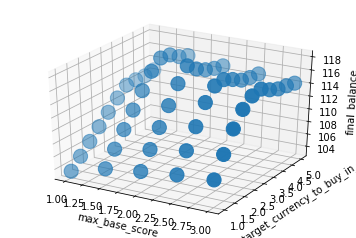

In [116]:
trading_fee_decimal = 0.0025

old_week_count = 4
new_week_count = 4

currency_pair = CurrencyPair('USDT', 'BTC', 0.0005)
# currency_pair = CurrencyPair('USDT', 'ETH', 0.0005)
# currency_pair = CurrencyPair('USDT', 'LTC', 0.0005)
# currency_pair = CurrencyPair('USDT', 'XMR', 0.0005)
# currency_pair = CurrencyPair('BTC', 'ETH', 0.0005)
# currency_pair = CurrencyPair('BTC', 'LTC', 0.0005)
# currency_pair = CurrencyPair('BTC', 'XMR', 0.0005)

# max_base_score = 2 if base_currency_symbol == 'USDT' and target_currency_symbol == 'BTC' else 1
# if base_currency_symbol == 'USDT' and target_currency_symbol == 'ETH':
#     volume_unit_target_currency_to_buy_in_percents = 1.6
# elif base_currency_symbol == 'USDT' and target_currency_symbol == 'BTC':
#     volume_unit_target_currency_to_buy_in_percents = 3.5
# else:
#     volume_unit_target_currency_to_buy_in_percents = 1.3

currency_pair_evaluator = CurrencyPairEvaluator(currency_pair)
currency_pair_evaluator.evaluate()
